In [1]:
from typing import List, Optional
import torch
from torch import nn
from labml_helpers.module import Module

**1. Build basic structures**
   
    1.1.ShortcutProjection: Used for Bottleneck, to:
   
       Do projection when stride!= 1, to match input and output channels;
       Ease compute complexity while layers equal or deeper than 50.
   
    1.2.ResidualBlock: A basic structure of ResBlocks:

       Residual blocks, with batchnormalize and Relu;
       Forward passing;
       In this project, we use it for resnet-18.

    1.3.Block_withoutRes: Same with ResidualBlock, but cut off residual connection:

       return act(x) rather than act(x + shortcut);
       In this project, we use it for resnet-18 without residual.

    1.4.BottleneckResidualBlock: 

        Different convolution parameters/layers with ResidualBlock to compare them;
        In this project, we use it for resnet-50.

        

In [2]:
# 1.1 ShortcutProjection for projection and decrease compelexity of Computing
class ShortcutProjection(Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x: torch.Tensor):
        return self.bn(self.conv(x))

In [3]:
# 1.2 A basic structure of ResBlocks for resnet-18
class ResidualBlock(Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        super().__init__()

        # 2 3*3 kernel_size conv for each 2 blocks
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Insure input and output channels could be matched by projection
        if stride != 1 or in_channels != out_channels:
            self.shortcut = ShortcutProjection(in_channels, out_channels, stride)
        else:
            self.shortcut = nn.Identity()

        self.act2 = nn.ReLU()
        
    # forward propagation
    def forward(self, x: torch.Tensor):
        shortcut = self.shortcut(x)
        x = self.act1(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        return self.act2(x + shortcut)

In [4]:
# 1.3 cut off the shortcut-connection, to compare with resnet-18 in 1.2
class Block_withoutRes(Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = ShortcutProjection(in_channels, out_channels, stride)
        else:
            self.shortcut = nn.Identity()

        self.act2 = nn.ReLU()

    def forward(self, x: torch.Tensor):
        shortcut = self.shortcut(x)
        x = self.act1(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        
        # cut off the shortcut
        return self.act2(x)

In [5]:
# 1.4 A Resblock of resnet-50, for comparing with resnet-18 in 1.2
class BottleneckResidualBlock(Module):
    def __init__(self, in_channels: int, bottleneck_channels: int, out_channels: int, stride: int):
        super().__init__()

        # Adding projection layer (1*1 conv) in start (for reducing dimensions) and end (for reversing to original size)
        self.conv1 = nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, stride=1)
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)
        self.act2 = nn.ReLU()
        self.conv3 = nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1, stride=1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = ShortcutProjection(in_channels, out_channels, stride)
        else:
            self.shortcut = nn.Identity()

        self.act3 = nn.ReLU()

    def forward(self, x: torch.Tensor):
        shortcut = self.shortcut(x)
        x = self.act1(self.bn1(self.conv1(x)))
        x = self.act2(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.act3(x + shortcut)


**2. Build Residual network**
 
    2.1. ResNetBase: reproduce the structure in Table.1 of resnet paper:

<img src="images/Table.1.png" alt="Table.1" width="600">

    2.2. Base_NoResidual: The structure without residual.

In [6]:
# 2.1 Classic workflow of resnet
class ResNetBase(Module):
    def __init__(self, n_blocks: List[int], n_channels: List[int],
             bottlenecks: Optional[List[int]] = None,
             img_channels: int = 3, first_kernel_size: int = 7):
        
        # conv1: 7*7, 64, by stride=2, initial conv
        super().__init__()
        assert len(n_blocks) == len(n_channels)
        assert bottlenecks is None or len(bottlenecks) == len(n_channels)

        self.conv = nn.Conv2d(img_channels, 64, kernel_size=first_kernel_size, stride=2, padding=first_kernel_size // 2)
        self.bn = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 3*3 maxpool
        blocks = []
        prev_channels = 64 # output channels of conv1, same for every resnet-layers

        # conv2_x to conv5_x, for input with bottlenecks, use BottleneckResidualBlock for projection
        for i, channels in enumerate(n_channels):
            stride = 2 if len(blocks) == 0 else 1
            if bottlenecks is None:
                blocks.append(ResidualBlock(prev_channels, channels, stride=stride))
            else:
                blocks.append(BottleneckResidualBlock(prev_channels, bottlenecks[i], channels, stride=stride))
            prev_channels = channels
            for _ in range(n_blocks[i] - 1):
                if bottlenecks is None:
                    blocks.append(ResidualBlock(channels, channels, stride=1))
                else:
                    blocks.append(BottleneckResidualBlock(channels, bottlenecks[i], channels, stride=1))

        
        self.blocks = nn.Sequential(*blocks)         # sum all blocks
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  #  avgpool

    def forward(self, x: torch.Tensor):
        x = self.bn(self.conv(x))
        x = self.maxpool(x)  # maxpool after conv1
        x = self.blocks(x)
        x = self.avgpool(x)  
        x = x.view(x.size(0), -1)  
        return x



In [7]:
# 2.2 Residual without shrotcut (adding blocks by Block_withoutRes)
class Base_NoResidual(Module):
    def __init__(self, n_blocks: List[int], n_channels: List[int],
             bottlenecks: Optional[List[int]] = None,
             img_channels: int = 3, first_kernel_size: int = 7):
        super().__init__()
        assert len(n_blocks) == len(n_channels)
        assert bottlenecks is None or len(bottlenecks) == len(n_channels)

        self.conv = nn.Conv2d(img_channels, 64, kernel_size=first_kernel_size, stride=2, padding=first_kernel_size // 2)
        self.bn = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  
        blocks = []
        prev_channels = 64

        for i, channels in enumerate(n_channels):
            stride = 2 if len(blocks) == 0 else 1
            if bottlenecks is None:
                blocks.append(Block_withoutRes(prev_channels, channels, stride=stride)) # adding blocks by Block_withoutRes
            else:
                blocks.append(BottleneckResidualBlock(prev_channels, bottlenecks[i], channels, stride=stride))
            prev_channels = channels
            for _ in range(n_blocks[i] - 1):
                if bottlenecks is None:
                    blocks.append(Block_withoutRes(channels, channels, stride=1))
                else:
                    blocks.append(BottleneckResidualBlock(channels, bottlenecks[i], channels, stride=1))

        self.blocks = nn.Sequential(*blocks)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  

    def forward(self, x: torch.Tensor):
        x = self.bn(self.conv(x))
        x = self.maxpool(x)  
        x = self.blocks(x)
        x = self.avgpool(x) 
        x = x.view(x.size(0), -1)  
        return x


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

cuda_available = torch.cuda.is_available()
print(f"CUDA is available: {cuda_available}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if cuda_available:
    print(f"GPU device: {torch.cuda.get_device_name(0)}")

CUDA is available: True
GPU device: NVIDIA GeForce RTX 3070 Ti


**3. Build Resnet 18/18without shortcut/50, respectively**
 
    3.1.ResNet_18_CIFAR: fit parameters of resnet-18 and CIFAR.

    3.2.WithoutResNet_18_CIFAR: fit parameters while input 'Base_NoResidual'.

    3.3.ResNet_50_CIFAR: fit parameters of resnet-50 and CIFAR.

In [59]:
# 3.1.ResNet_18_CIFAR: fit parameters of resnet-18 and CIFAR
class ResNet_18_CIFAR(ResNetBase):
    def __init__(self):
        super().__init__(
            n_blocks=[2, 2, 2, 2],           # number of blocks in each conv'i'_x
            n_channels=[64, 128, 256, 512],  # output channel for each conv'i'_x
            bottlenecks=None,                 # Normal blocks
            img_channels=3,                  # CIFAR-10 with RGB, channels = 3
            first_kernel_size=3              # same as Table.1 in conv1
        )
        self.fc = nn.Linear(512, 999)  # fully connection with 1000-ways

    def forward(self, x):
        x = super().forward(x)  
        x = self.fc(x)
        x = nn.LogSoftmax(dim=1)(x) # softmax
        return x


In [60]:
# 3.2 fit parameters while input 'Base_NoResidual'
class WithoutResNet_18_CIFAR(Base_NoResidual):
    def __init__(self):
        super().__init__(
            n_blocks=[2, 2, 2, 2],           
            n_channels=[64, 128, 256, 512],  
            bottlenecks=None,                 
            img_channels=3,                  
            first_kernel_size=3              
        )
        self.fc = nn.Linear(512, 999)  

    def forward(self, x):
        x = super().forward(x)
        x = self.fc(x)
        x = nn.LogSoftmax(dim=1)(x)
        return x

In [61]:
# 3.3.ResNet_50_CIFAR: fit parameters of resnet-50 and CIFAR.
class ResNet_50_CIFAR(ResNetBase):
    def __init__(self):
        super().__init__(
            n_blocks=[3, 4, 6, 3],           
            n_channels=[256, 512, 1024, 2048],  
            bottlenecks=[64, 128, 256, 512],  # use bottleneckResidualblock
            img_channels=3,
            first_kernel_size=3
        )
        self.fc = nn.Linear(2048, 999)

    def forward(self, x):
        x = super().forward(x)
        x = self.fc(x)
        x = nn.LogSoftmax(dim=1)(x)
        return x



**4. Loading CIFAR and Train dataset**
 
    4.1.Downloading CIFAR and loading Train/Test sets by new transform.

    4.2.Define train/test function for 3 models.

    4.3.Main training loops for 3 models and record their test errors.

    4.4.Plot test err into one graph and comparing.

In [62]:
# 4.1.Downloading CIFAR and loading Train/Test sets by new transform
root_CIFAR = './24450936_COMP7250Project/ResNet_code/data'
trainset_no_norm = torchvision.datasets.CIFAR10(
    root=root_CIFAR,
    train=True, 
    download=True, 
    transform=transforms.ToTensor()
)
trainloader_no_norm = DataLoader(trainset_no_norm, batch_size=128, shuffle=False, num_workers=2)

# compute mean and std on original dataset
mean = torch.zeros(3)
std = torch.zeros(3)
total_images = 0
for images, _ in trainloader_no_norm:
    batch_samples = images.size(0)  
    images = images.view(batch_samples, images.size(1), -1)  # align into (batch_size, channels, height*width)
    mean += images.mean(2).sum(0)  
    std += images.std(2).sum(0)
    total_images += batch_samples
mean /= total_images  
std /= total_images

print(f"Computed mean: {mean}")
print(f"Computed std: {std}")

# define transform with Normalize
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# use new transform to load train/test sets
trainset = torchvision.datasets.CIFAR10(
    root=root_CIFAR, train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root=root_CIFAR, train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)




# Create model/optimizer/Lossfunction for 3 models

# resnet-18
model_18 = ResNet_18_CIFAR().to(device)
optimizer_18 = optim.SGD(model_18.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler_18 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_18, T_max=200)

# resnet-18 without shortcut
model_18_noRes = WithoutResNet_18_CIFAR().to(device)
optimizer_18_noRes = optim.SGD(model_18_noRes.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler_18_noRes = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_18_noRes, T_max=200)

# resnet-50
model_50 = ResNet_50_CIFAR().to(device)
optimizer_50 = optim.SGD(model_50.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler_50 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_50, T_max=200)

# use NLLLoss as lossfunction 
criterion = nn.NLLLoss()

Files already downloaded and verified
Computed mean: tensor([0.4914, 0.4822, 0.4465])
Computed std: tensor([0.2023, 0.1994, 0.2010])
Files already downloaded and verified
Files already downloaded and verified


In [55]:
# 4.2 train the resnet-18
def train_18(epoch):
    model_18.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_18.zero_grad()
        outputs = model_18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_18.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 100 == 99:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}')
            running_loss = 0.0
    train_error = 1 - correct / total
    return train_error

def test_18():
    model_18.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_18(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_error = 1 - correct / total
    print(f'Test Error (ResNet-18): {test_error:.4f}')
    return test_error

In [63]:
# 4.2 train the resnet-18 without shortcut
def train_18_noRes(epoch):
    model_18_noRes.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_18_noRes.zero_grad()
        outputs = model_18_noRes(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_18_noRes.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 100 == 99:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}')
            running_loss = 0.0
    train_error = 1 - correct / total
    return train_error

def test_18_noRes():
    model_18_noRes.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_18_noRes(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_error = 1 - correct / total
    print(f'Test Error (WithoutResNet-18): {test_error:.4f}')
    return test_error

In [64]:
# 4.2 train the resnet-50
def train_50(epoch):
    model_50.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_50.zero_grad()
        outputs = model_50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_50.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 100 == 99:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}')
            running_loss = 0.0
    train_error = 1 - correct / total
    return train_error

def test_50():
    model_50.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_50(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_error = 1 - correct / total
    print(f'Test Error (ResNet-50): {test_error:.4f}')
    return test_error

In [65]:
# 4.3.main of resnet-18 and records test errors
num_epochs = 50
best_acc_18 = 0.0

train_errors_18 = []
test_errors_18 = []
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}')
    train_error = train_18(epoch)
    test_error = test_18()
    train_errors_18.append(train_error)
    test_errors_18.append(test_error)
    scheduler_18.step()
    if 1 - test_error > best_acc_18:
        best_acc_18 = 1 - test_error
        torch.save(model_18.state_dict(), 'best_model_18.pth')
print(f'Best Test Accuracy (ResNet-18): {best_acc_18:.2f}%')


Epoch 1/50
[Epoch 1, Batch 100] Loss: 3.011
[Epoch 1, Batch 200] Loss: 1.888
[Epoch 1, Batch 300] Loss: 1.745
Test Error (ResNet-18): 0.5710

Epoch 2/50
[Epoch 2, Batch 100] Loss: 1.601
[Epoch 2, Batch 200] Loss: 1.521
[Epoch 2, Batch 300] Loss: 1.473
Test Error (ResNet-18): 0.5022

Epoch 3/50
[Epoch 3, Batch 100] Loss: 1.393
[Epoch 3, Batch 200] Loss: 1.331
[Epoch 3, Batch 300] Loss: 1.291
Test Error (ResNet-18): 0.4448

Epoch 4/50
[Epoch 4, Batch 100] Loss: 1.213
[Epoch 4, Batch 200] Loss: 1.204
[Epoch 4, Batch 300] Loss: 1.170
Test Error (ResNet-18): 0.4017

Epoch 5/50
[Epoch 5, Batch 100] Loss: 1.115
[Epoch 5, Batch 200] Loss: 1.111
[Epoch 5, Batch 300] Loss: 1.073
Test Error (ResNet-18): 0.3725

Epoch 6/50
[Epoch 6, Batch 100] Loss: 1.036
[Epoch 6, Batch 200] Loss: 1.033
[Epoch 6, Batch 300] Loss: 1.014
Test Error (ResNet-18): 0.3431

Epoch 7/50
[Epoch 7, Batch 100] Loss: 0.986
[Epoch 7, Batch 200] Loss: 0.962
[Epoch 7, Batch 300] Loss: 0.945
Test Error (ResNet-18): 0.3121

Epoch

In [66]:
# 4.3.main of resnet-18 without shortcut and records test errors
num_epochs = 50
best_acc_18_noRes = 0.0

train_errors_18_noRes = []
test_errors_18_noRes = []
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}')
    train_error = train_18_noRes(epoch)
    test_error = test_18_noRes()
    train_errors_18_noRes.append(train_error)
    test_errors_18_noRes.append(test_error)
    scheduler_18_noRes.step()
    if 1 - test_error > best_acc_18_noRes:
        best_acc_18_noRes = 1 - test_error
        torch.save(model_18_noRes.state_dict(), 'best_model_18_noRes.pth')
print(f'Best Test Accuracy (WithoutResNet-18): {best_acc_18_noRes:.2f}%')


Epoch 1/50
[Epoch 1, Batch 100] Loss: 2.212
[Epoch 1, Batch 200] Loss: 1.913
[Epoch 1, Batch 300] Loss: 1.810
Test Error (WithoutResNet-18): 0.6335

Epoch 2/50
[Epoch 2, Batch 100] Loss: 1.701
[Epoch 2, Batch 200] Loss: 1.628
[Epoch 2, Batch 300] Loss: 1.569
Test Error (WithoutResNet-18): 0.5673

Epoch 3/50
[Epoch 3, Batch 100] Loss: 1.497
[Epoch 3, Batch 200] Loss: 1.467
[Epoch 3, Batch 300] Loss: 1.440
Test Error (WithoutResNet-18): 0.5063

Epoch 4/50
[Epoch 4, Batch 100] Loss: 1.382
[Epoch 4, Batch 200] Loss: 1.350
[Epoch 4, Batch 300] Loss: 1.317
Test Error (WithoutResNet-18): 0.4364

Epoch 5/50
[Epoch 5, Batch 100] Loss: 1.261
[Epoch 5, Batch 200] Loss: 1.237
[Epoch 5, Batch 300] Loss: 1.212
Test Error (WithoutResNet-18): 0.4224

Epoch 6/50
[Epoch 6, Batch 100] Loss: 1.179
[Epoch 6, Batch 200] Loss: 1.137
[Epoch 6, Batch 300] Loss: 1.127
Test Error (WithoutResNet-18): 0.3752

Epoch 7/50
[Epoch 7, Batch 100] Loss: 1.080
[Epoch 7, Batch 200] Loss: 1.100
[Epoch 7, Batch 300] Loss: 1

In [68]:
# 4.3.main of resnet-50 and records test errors
num_epochs = 50
best_acc_50 = 0.0

train_errors_50 = []
test_errors_50 = []
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}')
    train_error = train_50(epoch)
    test_error = test_50()
    train_errors_50.append(train_error)
    test_errors_50.append(test_error)
    scheduler_50.step()
    if 1 - test_error > best_acc_50:
        best_acc_50 = 1 - test_error
        torch.save(model_50.state_dict(), 'best_model_50.pth')
print(f'Best Test Accuracy (ResNet-50): {best_acc_50:.2f}%')


Epoch 1/50
[Epoch 1, Batch 100] Loss: 4.081
[Epoch 1, Batch 200] Loss: 2.338
[Epoch 1, Batch 300] Loss: 2.178
Test Error (ResNet-50): 0.7615

Epoch 2/50
[Epoch 2, Batch 100] Loss: 1.961
[Epoch 2, Batch 200] Loss: 1.878
[Epoch 2, Batch 300] Loss: 1.823
Test Error (ResNet-50): 0.6358

Epoch 3/50
[Epoch 3, Batch 100] Loss: 1.704
[Epoch 3, Batch 200] Loss: 1.651
[Epoch 3, Batch 300] Loss: 1.610
Test Error (ResNet-50): 0.5771

Epoch 4/50
[Epoch 4, Batch 100] Loss: 1.528
[Epoch 4, Batch 200] Loss: 1.510
[Epoch 4, Batch 300] Loss: 1.500
Test Error (ResNet-50): 0.5098

Epoch 5/50
[Epoch 5, Batch 100] Loss: 1.436
[Epoch 5, Batch 200] Loss: 1.383
[Epoch 5, Batch 300] Loss: 1.378
Test Error (ResNet-50): 0.4773

Epoch 6/50
[Epoch 6, Batch 100] Loss: 1.324
[Epoch 6, Batch 200] Loss: 1.317
[Epoch 6, Batch 300] Loss: 1.273
Test Error (ResNet-50): 0.4257

Epoch 7/50
[Epoch 7, Batch 100] Loss: 1.247
[Epoch 7, Batch 200] Loss: 1.230
[Epoch 7, Batch 300] Loss: 1.191
Test Error (ResNet-50): 0.4274

Epoch

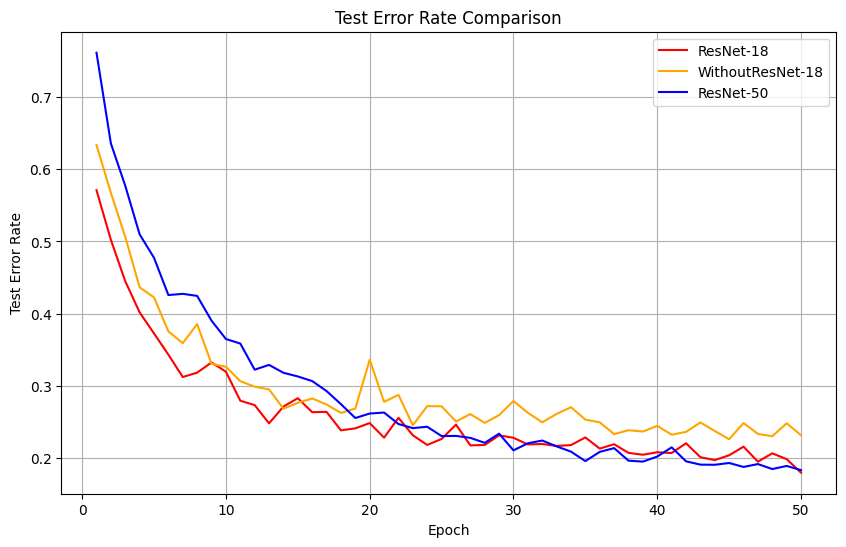

In [69]:
# 4.4 plot test err for 3 models and compare them
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, test_errors_18, 'r-', label='ResNet-18')
plt.plot(epochs, test_errors_18_noRes, 'orange', label='WithoutResNet-18')
plt.plot(epochs, test_errors_50, 'b-', label='ResNet-50')
plt.xlabel('Epoch')
plt.ylabel('Test Error Rate')
plt.title('Test Error Rate Comparison')
plt.legend()
plt.grid(True)
plt.show()